In [40]:
def CRRA(m,cons):
        """
        ------------------------------
        === CRRA Utility Function ===
        ------------------------------
        <inputs>
        ・m: パラメータ等を格納したコンストラクタ
        ・cons: 消費量
        ・gamma: 異時点間の代替弾力性の逆数(相対的リスク回避度)
        <output>
        ・consとgamma の下での効用水準
        """
        import numpy as np
        gamma = m.gamma
        
        if cons <0: 
            utility = -10000 #消費量が負値の場合、ペナルティを与える(最適化問題におけるトリック)
        else:
            if gamma != 1.0:
                utility = (cons ** (1-gamma)) / (1-gamma)
            else:
                utility = np.log(cons)
                
        return utility

In [ ]:
def BellmanEq(m,a,w,ap,v1_interp,v2_interp,p):
    """
    -----------------------------------------------
    === (k,k')を所与とした時にベルマン方程式を返す関数 ===
    -----------------------------------------------
    <input>
    ・m: パラメータ等を格納したコンストラクタ
    ・capital: 今期の資本保有量(k)
    ・kprime: 来期の資本保有量(k')
    ・v_: 補間した来期の価値関数
    (※Matlabコード上ではBellmanEq関数内で補間した価値関数を定義しているが、
    今回は明示的に関数の引数として扱う(capitalも同様))
    <output>
    ・value: (k,k')に対するベルマン方程式
    (※コード上では"最小化問題"を解くので符号を反転させた値を返す)
    """
    # from CRRA import CRRA

    # alpha, beta = m.alpha, m.beta

    if kprime < 0: #(1): k'は正の値しか取らないので、ペナルティを与えてその値が選ばれないようにする
        
        value = -10000.0
    
    else:

        wealth = (1+m.rent)*a + w #今期の資本保有量で実現される生産量
        cons = wealth - ap #消費量
        util = CRRA(m,cons) #効用水準
        value = util + beta*(p*v1_interp(ap) + (1-p)*v2_interp(ap)) #u(c)+βV_{t+1}(k')

    value = -1*value #(2): コード上では"最小化問題"を解くので符号を反転させた値を返す

    return value

In [41]:
#カリブレーション
class Model():
    """
    ロビンソン・クルーソーモデルを解くためのパラメータを含む class を定義する。
    """
    def __init__(self,
        beta = 0.985, # 割引因子
        gamma = 1.0, # 異時点間の代替弾力性の逆数
        rent = 1.01-1.0,
        wH = 1.0,
        wL = 0.1,
        p1 = 0.9,
        p2 = 0.5,
        na = 101,     # 資本のグリッド数
        amax = 10.0, #1.0,  # 資本グリッドの最大値
        amin = 0.0, #0.05, # 資本グリッドの最小値
        maxit = 10000, # 繰り返し計算の最大値
        tol = 1e-5,   # 許容誤差(STEP 4)
        ): 
        
        self.beta, self.gamma, self.rent = beta, gamma, rent 
        self.wH, self.wL, self.p1, self.p2 = wH, wL, p1, p2 
        self.na, self.amax, self.amin = na, amax, amin 
        self.maxit, self.tol = maxit, tol
        self.agrid = np.linspace(amin,amax,na) # 資本のグリッド

In [42]:
#必要な関数・モジュールを呼び出す
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.interpolate import interp1d
from scipy.optimize import fmin
# from CRRA import CRRA, mu_CRRA
# from BellmanEq import BellmanEq

In [43]:
#収束に関するパラメータ
it = 1 #ループカウンター
dif1 = 1.0 #価値関数の繰り返し誤差
dif2 = 1.0 #政策関数の繰り返し誤差

#STEP 1(b): 価値関数・政策関数の初期値を設定
m = Model()
vfcn = 10000*np.ones((m.na,2)) # it should be large enough
pfcn = np.ones_like(vfcn)
Tvfcn = np.zeros_like(vfcn)
Tpfcn = np.zeros_like(vfcn)
# vkp1 = np.empty((m.na,m.na))
# vkp2 = np.empty((m.na,m.na))
# v_conv = [] #価値関数の繰り返し誤差を記録していく。各繰り返しごとにリストに追加していく。
# p_conv = [] #政策関数の繰り返し誤差を記録していく。

In [44]:
# #STEP 2: 効用関数の組み合わせ

# #効用関数の初期値(消費が0以下になる組み合わせにはペナルティ)
# #MATLABコード上はループで明示的にペナルティを与えているが、pythonコードではCRRA関数において先に負の消費にペナルティを与えている。
# util = -10000.0*np.ones((m.na,m.na,2))

# #(k,k')の組み合わせについて効用を計算
# for i in range(m.na): #今期の資本量
#     for j in range(m.na): #来期の資本量
        
#         cH = (1.0+m.rent)*m.agrid[i] - m.agrid[j] + m.wH
#         cL = (1.0+m.rent)*m.agrid[i] - m.agrid[j] + m.wL
        
#         if cH > 0.0:
#             util[i,j,0] = CRRA(m,cH)
#         if cL > 0.0:
#             util[i,j,1] = CRRA(m,cL)

In [46]:
#STEP 3: 価値関数を繰り返し計算

while (it<m.maxit) & (dif1>m.tol):

    #ベルマン方程式: V(k;k')
    for i in range(m.na):
        
        # vkp1[i,:] = util[i,:,0] + m.beta*(m.p1*vfcn[:,0]+(1-m.p1)*vfcn[:,1])
        # vkp2[i,:] = util[i,:,1] + m.beta*(m.p2*vfcn[:,0]+(1-m.p2)*vfcn[:,1])
        
        #最適化: 各kについてV(k,k')を最大にするk'を探す
        ploc1 = np.argmax(vkp1[i,:])
        Tvfcn[i,0] = vkp1[i,ploc1]
        Tpfcn[i,0] = m.agrid[ploc1]
        ploc2 = np.argmax(vkp2[i,:])
        Tvfcn[i,1] = vkp2[i,ploc2]
        Tpfcn[i,1] = m.agrid[ploc2]
    
    #繰り返し誤差を確認
    dif1 = np.max(np.abs((Tvfcn-vfcn)/vfcn))
    dif2 = np.max(np.abs((Tpfcn-pfcn)/pfcn)) 
    
    #価値関数・政策関数をアップデート
    vfcn = np.copy(Tvfcn)
    pfcn = np.copy(Tpfcn)

    print(f"iteration index: {it}, iteration diff of value: {dif1:.7f}")

    #収束途中の繰り返し計算誤差を保存
    # v_conv.append(dif1)
    # p_conv.append(dif2)

    it += 1

iteration index: 1, iteration diff of value: 0.0152303
iteration index: 2, iteration diff of value: 0.0151187
iteration index: 3, iteration diff of value: 0.0150717
iteration index: 4, iteration diff of value: 0.0150515
iteration index: 5, iteration diff of value: 0.0150425
iteration index: 6, iteration diff of value: 0.0150383
iteration index: 7, iteration diff of value: 0.0150362
iteration index: 8, iteration diff of value: 0.0150351
iteration index: 9, iteration diff of value: 0.0150345
iteration index: 10, iteration diff of value: 0.0150342
iteration index: 11, iteration diff of value: 0.0150340
iteration index: 12, iteration diff of value: 0.0150340
iteration index: 13, iteration diff of value: 0.0150341
iteration index: 14, iteration diff of value: 0.0150342
iteration index: 15, iteration diff of value: 0.0150344
iteration index: 16, iteration diff of value: 0.0150346
iteration index: 17, iteration diff of value: 0.0150349
iteration index: 18, iteration diff of value: 0.0150352


C:\Users\takek\AppData\Local\Temp\ipykernel_15376\633825512.py:21: RuntimeWarning: divide by zero encountered in divide
  dif2 = np.max(np.abs((Tpfcn-pfcn)/pfcn))
C:\Users\takek\AppData\Local\Temp\ipykernel_15376\633825512.py:21: RuntimeWarning: invalid value encountered in divide
  dif2 = np.max(np.abs((Tpfcn-pfcn)/pfcn))


iteration index: 19, iteration diff of value: 0.0150355
iteration index: 20, iteration diff of value: 0.0150359
iteration index: 21, iteration diff of value: 0.0150362
iteration index: 22, iteration diff of value: 0.0150367
iteration index: 23, iteration diff of value: 0.0150371
iteration index: 24, iteration diff of value: 0.0150375
iteration index: 25, iteration diff of value: 0.0150380
iteration index: 26, iteration diff of value: 0.0150385
iteration index: 27, iteration diff of value: 0.0150390
iteration index: 28, iteration diff of value: 0.0150395
iteration index: 29, iteration diff of value: 0.0150400
iteration index: 30, iteration diff of value: 0.0150405
iteration index: 31, iteration diff of value: 0.0150411
iteration index: 32, iteration diff of value: 0.0150416
iteration index: 33, iteration diff of value: 0.0150422
iteration index: 34, iteration diff of value: 0.0150428
iteration index: 35, iteration diff of value: 0.0150434
iteration index: 36, iteration diff of value: 0.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


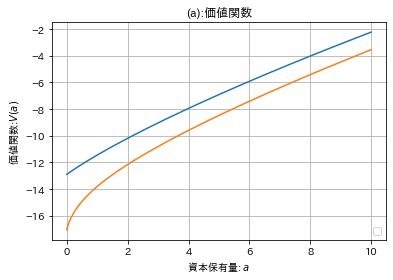

In [47]:
fig, ax = plt.subplots()
ax.plot(m.agrid,vfcn[:,0])
ax.plot(m.agrid,vfcn[:,1])
ax.set(title="(a):価値関数",xlabel=r"資本保有量: $a$", ylabel=r"価値関数:$V(a)$") #,xlim=(0,m.kmax))
ax.legend(loc="lower right")
ax.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


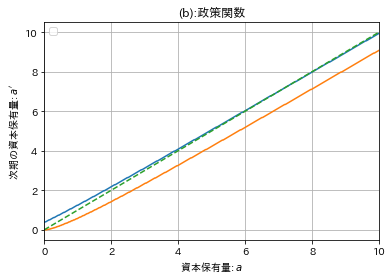

In [48]:
fig, ax = plt.subplots()
ax.plot(m.agrid, pfcn[:,0])
ax.plot(m.agrid, pfcn[:,1])
ax.plot(m.agrid, m.agrid, ls="--")
ax.set(title="(b):政策関数",xlabel=r"資本保有量: $a$", ylabel=r"次期の資本保有量: $a'$",xlim=(0,m.amax))
ax.legend(loc="upper left")
ax.grid()
plt.show()